In [119]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
import re
import os
from lib import get_stop_words, get_text, get_lem_words
from multiprocessing import Pool
from itertools import repeat, chain
import pickle
import matplotlib.pyplot as plt


In [121]:
NUM_PROCESSES = 20

In [194]:
# project gutenberg text has a lot of extra stuff at the beginning and end
def get_text_no_gutenberg(raw_text):
    return re.split('^\*\*\*(.*)\*\*\*$', raw_text, flags=re.MULTILINE)[2]
    
def remove_single_letter(text):
    text = re.sub(r'\b\w\b', ' ', text)
    return text

# split the raw text into chapters
def split_chapters(text, roman_numeral=True):
    if roman_numeral:
        return re.split(r'(^\s?CHAPTER [IVXLCDM]+.*$)', text, flags=re.IGNORECASE | re.MULTILINE | re.ASCII)
    else:
        return re.split(r'(^\s?CHAPTER \d+.*$)', text, flags=re.IGNORECASE | re.MULTILINE | re.ASCII)

# sometimes the contents lists chapters that are in table of contents. here we just remove chapters that are too short.
# here we also delete the first chapter, which is just the table of contents and preface
def chapter_longer_than(raw_chapters, n=150):
    return list(filter(lambda c: len(c) > n, raw_chapters))

# split remove stopwords
def remove_stopwords(text, stopwords):
    return re.sub(r'\b(' + '|'.join(stopwords) + r')\b', '', text)

def expand_contractions(text):
    flags = re.MULTILINE | re.IGNORECASE | re.ASCII
    text = re.sub(r'’', "'", text, flags=flags)
    text = re.sub(r"won\'t", r"will not", text, flags=flags)
    text = re.sub(r"can\'t", r"cannot", text, flags=flags)
    text = re.sub(r"i\'m", r"i am", text, flags=flags)
    text = re.sub(r"ain\'t", r"is not", text, flags=flags)
    text = re.sub(r"(\w+)'ll", r"\g<1> will", text, flags=flags)
    text = re.sub(r"(\w+)n't", '\g<1> not', text, flags=flags)
    text = re.sub(r"(\w+)\'ve", r"\g<1> have", text, flags=flags)
    text = re.sub(r"(\w+)\'s", r"\g<1> is", text, flags=flags)
    text = re.sub(r"(\w+)\'re", r"\g<1> are", text, flags=flags)
    text = re.sub(r"(\w+)\'d", r"\g<1> would", text, flags=flags)
    return text

# theres a ton of whitespace that we dont want
def remove_extra_spaces(text):
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

def replace_common_dots(text):
    text =  re.sub(r'dr\.', 'dr ', text)
    text =  re.sub(r'mr\. ', 'mr ', text)
    return text

def compress_abbr(text):
    pattern = r'\b(?:[a-zA-Z]\.){2,}\b.*?'
    matches = re.finditer(pattern, text, re.MULTILINE | re.IGNORECASE)
    abbr = set(map(lambda m: m.group(), matches))
    for a in abbr:
        text = text.replace(a, a.replace('.', ''))
    return text

def replace_sent_terminators(text):
    text = re.sub(r'\?', r'\.', text)
    text = re.sub(r'\!', r'\.', text)
    return text

def get_lem(fn):
    lem = {}
    lem_regex = []
    with open(fn, 'r', encoding='utf-8-sig') as f:
        for i in f:
            text = [j for j in i.lower().split()]
            if text[0] not in lem:
                lem[text[0]] = [text[1]]
            else:
                lem[text[0]].append(text[1])
    for word, lemmas in lem.items():
        lem_regex.append([word, fr'\b({"|".join(lemmas)})\b'])
    return lem_regex
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', lambda m: "." if m.group(0) == "." else " ", text)
    return text

def split_sentences(text):
    return re.split(r"[.]", text)

def lemmatization(text, lem):
    for lemma, lem_regex in lem:
        text = re.sub(lem_regex, lemma, text)
    return text

def trim(text):
    for i in range(len(text)):
        text[i] = text[i].strip()
    return text

In [195]:
books = [
    {
        'fn': 'a-study-in-scarlet.txt',
        'roman_numeral': True,
        'remove_first_chapter': True,
    },
    {
        'fn': 'the-valley-of-fear.txt',
        'roman_numeral': False,
        'remove_first_chapter': True
    },
    {
        'fn': 'the-hound-of-the-baskervilles.txt',
        'roman_numeral': False,
        'remove_first_chapter': True,
    },
    {
        'fn':  'the-mystery-of-cloomber.txt',
        'roman_numeral': True,
        'remove_first_chapter': True,
    },
    {
        'fn': 'the-sign-of-four.txt',
        'roman_numeral': True,
        'remove_first_chapter': True,
    },
]

In [196]:
basedir = '../books/'
stop_words = get_stop_words('stopwords.txt')
lem = get_lem('lemmatization-en.txt')
book_i = 2
book_fn = books[book_i]['fn']
book_rom_num = books[book_i]['roman_numeral']
remove_first_chapter = books[book_i]['remove_first_chapter']


def clean_by_chapter(raw_chapter, stop_words, lem):
    raw_chapter = remove_extra_spaces(raw_chapter)

    raw_chapter = expand_contractions(raw_chapter)
    raw_chapter = remove_extra_spaces(raw_chapter)

    raw_chapter = replace_common_dots(raw_chapter)
    raw_chapter = remove_extra_spaces(raw_chapter)

    raw_chapter = compress_abbr(raw_chapter)
    raw_chapter = remove_extra_spaces(raw_chapter)

    raw_chapter = replace_sent_terminators(raw_chapter)
    raw_chapter = remove_extra_spaces(raw_chapter)

    raw_chapter = remove_punctuation(raw_chapter)
    raw_chapter = remove_extra_spaces(raw_chapter)

    raw_chapter = remove_stopwords(raw_chapter, stop_words)
    raw_chapter = remove_extra_spaces(raw_chapter)

    raw_chapter = lemmatization(raw_chapter, lem)
    raw_chapter = remove_extra_spaces(raw_chapter)
    return raw_chapter


def clean_all_text(book_fn, base_dir, stop_words, lem, book_rom_num, remove_first_chapter):

    # get the raw text and make it all lower case
    raw_text = get_text(book_fn, base_dir)
    raw_text = raw_text.lower()
    raw_text = get_text_no_gutenberg(raw_text)

    # split into chapters so we can parallelize all of the text operations
    raw_chapters = split_chapters(raw_text, book_rom_num)

    # keep only the chapter's texts and none of the preface and content info
    longer_than_n = list(map(lambda c: len(c) > 100, raw_chapters))
    longer_than_n[0] = longer_than_n[0] if not remove_first_chapter else False
    chapt_start = next(i for i,v in enumerate(longer_than_n) if v)
    raw_chapters = raw_chapters[chapt_start::2]

    # map the cleaning operations onto each chapter
    with Pool(NUM_PROCESSES) as pool:
        raw_chapters = pool.starmap(clean_by_chapter, zip(raw_chapters, repeat(stop_words), repeat(lem)))

    # split each chapter into sentences
    def sentence_helper(text):
        s = split_sentences(text)
        s = trim(s)
        s = list(filter(lambda x: x != '', s))
        return s
    raw_chapter_sentences = list(map(sentence_helper, raw_chapters))

    # rejoin the sentences from the cleaned chapter sentences so we can remove empty sentences
    raw_chapters = list(map(lambda x: '. '.join(x), raw_chapter_sentences))
    raw_chapters = list(map(remove_extra_spaces, raw_chapters))

    # rejoin the clean text by joining all of the chapters sentences
    raw_text = '. '.join(chain(*raw_chapter_sentences))
    raw_text = remove_extra_spaces(raw_text)

    # here we are seperating each sentence by new line and appending the chapter and sentence number to the beginning of each sentence
    marked_text = ''
    for i in range(len(raw_chapter_sentences)):
        for j in range(len(raw_chapter_sentences[i])):
            marked_text += f'((({i};;;{j}))) {raw_chapter_sentences[i][j]}\n'
    return raw_text, raw_chapters, raw_chapter_sentences, marked_text



In [197]:
book_i = 0
book_fn = books[book_i]['fn']
book_rom_num = books[book_i]['roman_numeral']
remove_first_chapter = books[book_i]['remove_first_chapter']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = clean_all_text(book_fn, basedir, stop_words, lem, book_rom_num, remove_first_chapter)


In [198]:
# save the cleaned text
def save_cleaned_text(book_fn, base_dir, raw_text, raw_chapters, raw_chapter_sentences, marked_text):
    with open(os.path.join(base_dir, book_fn + '_cleaned.txt'), 'w', encoding='utf-8') as f:
        f.write(raw_text)
    with open(os.path.join(base_dir, book_fn + '_cleaned_chapters.pkl'), 'wb') as f:
        pickle.dump(raw_chapters, f)
    with open(os.path.join(base_dir, book_fn + '_cleaned_chapter_sentences.pkl'), 'wb') as f:
        pickle.dump(raw_chapter_sentences, f)
    with open(os.path.join(base_dir, book_fn + '_cleaned_marked.txt'), 'w', encoding='utf-8') as f:
        f.write(marked_text)

# read in the cleaned text
def read_cleaned_text(book_fn, base_dir):
    with open(os.path.join(base_dir, book_fn + '_cleaned.txt'), 'r', encoding='utf-8') as f:
        raw_text = f.read()
    with open(os.path.join(base_dir, book_fn + '_cleaned_chapters.pkl'), 'rb') as f:
        raw_chapters = pickle.load(f)
    with open(os.path.join(base_dir, book_fn + '_cleaned_chapter_sentences.pkl'), 'rb') as f:
        raw_chapter_sentences = pickle.load(f)
    with open(os.path.join(base_dir, book_fn + '_cleaned_marked.txt'), 'r', encoding='utf-8') as f:
        marked_text = f.read()

    return raw_text, raw_chapters, raw_chapter_sentences, marked_text

In [199]:
# go through the process of cleaning the text then write out the cleaned text to files
basedir = '../books/'
stop_words = get_stop_words('stopwords.txt')
lem = get_lem('lemmatization-en.txt')

for book_i in range(len(books)):
    book_fn = books[book_i]['fn']
    book_rom_num = books[book_i]['roman_numeral']
    remove_first_chapter = books[book_i]['remove_first_chapter']

    print(f'Cleaning {book_fn}')
    raw_text, raw_chapters, raw_chapter_sentences, marked_text = clean_all_text(book_fn, basedir, stop_words, lem, book_rom_num,remove_first_chapter)
    print(f'Saving {book_fn}')
    save_cleaned_text(book_fn, 'clean-data', raw_text, raw_chapters, raw_chapter_sentences, marked_text)


Cleaning a-study-in-scarlet.txt
Saving a-study-in-scarlet.txt
Cleaning the-valley-of-fear.txt
Saving the-valley-of-fear.txt
Cleaning the-hound-of-the-baskervilles.txt
Saving the-hound-of-the-baskervilles.txt
Cleaning the-mystery-of-cloomber.txt
Saving the-mystery-of-cloomber.txt
Cleaning the-sign-of-four.txt
Saving the-sign-of-four.txt


In [ ]:
# example of reading in cleaned text
book_i = 1
book_fn = books[book_i]['fn']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = read_cleaned_text(book_fn, 'clean-data')

In [ ]:
raw_text[:1000]

In [ ]:
raw_chapters[0][:1000]

In [ ]:
raw_chapter_sentences[0][:10]

In [ ]:
marked_text[:1000]

In [204]:
def get_matches(marked_text, word):
    pattern = rf'^\(\(\((\d+;;;\d+)\)\)\).*?\b({word})\b.*?$'
    matches = re.finditer(pattern, marked_text, re.MULTILINE | re.IGNORECASE)
    return list(matches)
def get_chapter_sentence(match):
    chap,sent = match.group(1).split(';;;')
    return int(chap), int(sent)
def get_chapter_from_marked(marked_text, chapter_num):
    pattern = rf'^\(\(\({chapter_num};;;\d+\)\)\).*?$'
    matches = re.finditer(pattern, marked_text, re.MULTILINE | re.IGNORECASE)
    return '\n'.join([match.group(0) for match in matches])
def print_all_matches(matches):
    for match in matches:
        chap, sent = get_chapter_sentence(match)
        print(f'Chapter {chap+1}, Sentence {sent+1}: {match.group(0).split("))) ")[1]}')
    
def all_matches (matches):
    chap = []
    sent = []
    for match in matches:
        cha, sen = get_chapter_sentence(match)
        chap.append(cha)
        sent.append(sen)
    return chap, sent
def same_chap (chap_1, chap_2,sent_1):
    lis = []
    sent = []
    for x in range(len(chap_1)):
        if chap_1[x] in chap_2:
            lis.append(x)
    for x in lis:
        sent.append(sent_1[x])
    return sent, lis
    
def co_occur (match_1, match_2):
    ss = []
    chap_1, sent_1 = all_matches (match_1)
    chap_2, sent_2 = all_matches (match_2)
    s_1 = [x for x in chap_1 if x in chap_2]
    s_2 = [x for x in chap_2 if x in chap_1]
    sent_1, lis_1 = same_chap (chap_1, chap_2, sent_1)
    sent_2, lis_2 = same_chap (chap_2, chap_1, sent_2)
    for i in range(len(s_1)):
        for j in range(len(s_2)):
            if s_1[i] == s_2[j] and abs(sent_1[i] - sent_2[j]) <= 30:
                s = [s_1[i], s_2[j], sent_1[i], sent_2[j], lis_1[i], lis_2[j]]
                ss.append(s)
    try:
        print(f'Chapter {ss[0][0]+1}, Sentence {ss[0][2]+1}: {match_1[ss[0][4]].group(0).split("))) ")[1]}')
        print(f'Chapter {ss[0][1]+1}, Sentence {ss[0][3]+1}: {match_2[ss[0][5]].group(0).split("))) ")[1]}')
    except:
        print('No co-occur')
def count_per_chapter(csj, word):
    count = []
    for chapter in csj:
        matches = re.finditer(rf'\b({word})\b', chapter, re.MULTILINE | re.IGNORECASE)
        count.append(len(list(matches)))
    return count

def plot_count_per_chapter(chapter_sentences_joined, words:list, title=None):
    counts = [count_per_chapter(chapter_sentences_joined, word) for word in words]
    n = len(counts[0]) + 1
    fig = plt.figure(figsize=(10, 5))
    ax = plt.subplot(111)
    for i,c in enumerate(counts):
        ax.plot(range(1,n), c, label=f'{words[i]}')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Chapter')
    ax.set_ylabel('Number of References')
    if title is None:
        ax.set_title('References to Words in the Book')
    else:
        ax.set_title(title)
    plt.tight_layout()

---
# A Study in Scarlet

In [205]:
book_i = 0
book_fn = books[book_i]['fn']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = read_cleaned_text(book_fn, 'clean-data')
chapter_sentences_joined = [' '.join(chapter) for chapter in raw_chapter_sentences]
chapter_sentences_joined = [remove_extra_spaces(chapter) for chapter in chapter_sentences_joined]

## 1. When does the detective (or a pair) occur for the first time - chapter #, the sentence(s) # in a chapter

In [206]:
m = get_matches(marked_text, 'sherlock')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of sherlock in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'watson')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of watson in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

first occurrence of sherlock in chapter 1 sentence 40
"know sherlock holmes say care constant companion"
---
first occurrence of watson in chapter 1 sentence 23
"watson"


## 2. When is the crime first mentioned - the type of the crime and the details - chapter #, the sentence(s) # in a chapter


In [207]:
m = get_matches(marked_text, 'rache')[0]
chap, sent = get_chapter_sentence(m)
print(f'crime detail rache chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'poison')[2]
chap, sent = get_chapter_sentence(m)
print(f'crime detail victim poisoned around chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

crime detail rache chapter 3 sentence 211
"bare space scrawl blood red letter single word rache"
---
crime detail victim poisoned around chapter 3 sentence 268
"poison say sherlock holmes curtly stride"


## 3. When is the perpetrator first mentioned - chapter #, the sentence(s) # in a chapter

In [208]:

m = get_matches(marked_text, 'jefferson hope')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of the name jefferson hope in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'cabman')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of foreshadowing jefferson hope in terms of cabman in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'cab')[2]
chap, sent = get_chapter_sentence(m)
print(f'first reference to jefferson hope as a cab driver (unknown to them) in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')


first occurrence of the name jefferson hope in chapter 7 sentence 183
"gentleman cry flash eye let introduce mr jefferson hope murderer enoch drebber joseph stangerson"
---
first occurrence of foreshadowing jefferson hope in terms of cabman in chapter 4 sentence 44
"cabman drive"
---
first reference to jefferson hope as a cab driver (unknown to them) in chapter 3 sentence 262
"come victim wheel cab draw horse old shoe new fore leg"


## 4. What are the three words that occur around the perpetrator on each mention

Text(0.5, 1.0, 'A Study in Scarlet')

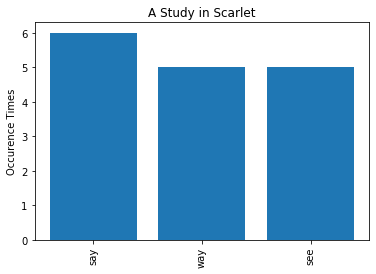

In [209]:
from groupings import *
dict = count_occurences(find_groupings(marked_text, 'jefferson hope'))
dict = count_occurences(find_groupings(marked_text, 'cabman'))
dict = count_occurences(find_groupings(marked_text, 'cab'))
first3pairs = {k: dict[k] for k in list(dict)[:3]}
x = first3pairs.keys()
y = first3pairs.values()
plt.bar(x, y)
plt.xticks(rotation=90)
plt.ylabel('Occurence Times')
plt.title('A Study in Scarlet') 

## 5. When and how the detective/detectives and the perpetrators co-occur

In [210]:
m_1 = get_matches(marked_text, 'sherlock')
m_2 = get_matches(marked_text, 'jefferson hope')
co_occur (m_1, m_2)
m_1 = get_matches(marked_text, 'watson')
m_2 = get_matches(marked_text, 'jefferson hope')
co_occur (m_1, m_2)
m_1 = get_matches(marked_text, 'sherlock')
m_2 = get_matches(marked_text, 'cabman')
co_occur (m_1, m_2)
m_1 = get_matches(marked_text, 'watson')
m_2 = get_matches(marked_text, 'cabman')
co_occur (m_1, m_2)

Chapter 7, Sentence 182: instant sharp click jangle metal sherlock holmes spring foot
Chapter 7, Sentence 183: gentleman cry flash eye let introduce mr jefferson hope murderer enoch drebber joseph stangerson
Chapter 12, Sentence 164: occur good quote old hunter account duly record dr watson journal obligation
Chapter 12, Sentence 148: man vindictive abandon think revenge face difficulty jefferson hope falter moment
Chapter 7, Sentence 182: instant sharp click jangle metal sherlock holmes spring foot
Chapter 7, Sentence 175: cabman help box
No co-occur


## 6. When are other suspects first introduced

In [211]:
m = get_matches(marked_text, 'arthur')[0]
chap, sent = get_chapter_sentence(m)
print(f'{chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'charpentier')[0]
chap, sent = get_chapter_sentence(m)
print(f' {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

6 sentence 68
"arthur charpentier sub lieutenant majesty navy cry gregson pompously rub fat hand inflate chest"
---
 6 sentence 12
"stay board house madame charpentier torquay terrace camberwell"


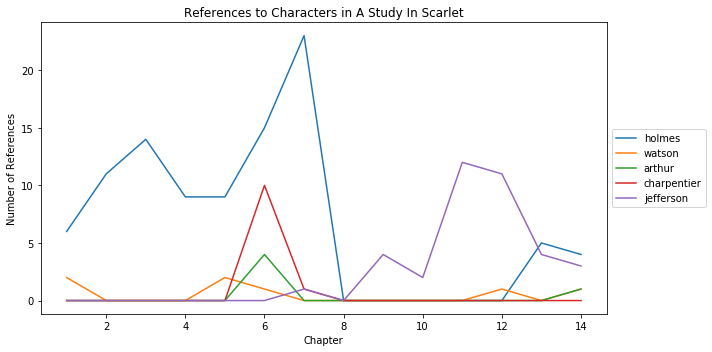

In [212]:
plot_count_per_chapter(chapter_sentences_joined, ['holmes', 'watson', 'arthur', 'charpentier', 'jefferson'], title='References to Characters in A Study In Scarlet')
plt.savefig('Figures/study-in-scarlet-references.png', dpi=500)


---
# The Valley Of Fear

In [213]:
book_i = 1
book_fn = books[book_i]['fn']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = read_cleaned_text(book_fn, 'clean-data')
chapter_sentences_joined = [' '.join(chapter) for chapter in raw_chapter_sentences]
chapter_sentences_joined = [remove_extra_spaces(chapter) for chapter in chapter_sentences_joined]

## 1. When does the detective (or a pair) occur for the first time - chapter #, the sentence(s) # in a chapter


In [214]:
m = get_matches(marked_text, 'sherlock')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of sherlock in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'watson')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of watson in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

first occurrence of sherlock in chapter 1 sentence 2
"sherlock holmes remark impatiently"
---
first occurrence of watson in chapter 1 sentence 15
"porlock watson nom de plume mere identification mark lie shifty evasive personality"


## 2. When is the crime first mentioned - the type of the crime and the details - chapter #, the sentence(s) # in a chapter

In [215]:
m = get_matches(marked_text, 'shotgun')[0]
chap, sent = get_chapter_sentence(m)
print(f'crime first mention of weapon chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'murder')[0]
chap, sent = get_chapter_sentence(m)
print(f'crime first mention of murder chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'douglas')[5]
chap, sent = get_chapter_sentence(m)
print(f'crime first mention of murder victim chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')


crime first mention of weapon chapter 2 sentence 216
"mention injury head discharge shotgun"
---
crime first mention of murder chapter 1 sentence 238
"say mr douglas birlstone manor house horribly murder night"
---
crime first mention of murder victim chapter 1 sentence 238
"say mr douglas birlstone manor house horribly murder night"


## 3. When is the perpetrator first mentioned - chapter #, the sentence(s) # in a chapter

In [216]:
m = get_matches(marked_text, 'mcginty')[0]
chap, sent = get_chapter_sentence(m)
print(f'first mention of boss bodymaster mcginty chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'moriarty')[0]
chap, sent = get_chapter_sentence(m)
print(f'first mention of moriarty chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

first mention of boss bodymaster mcginty chapter 5 sentence 276
"mcginty bodymaster mcginty"
---
first mention of moriarty chapter 1 sentence 20
"hear speak professor moriarty"


## 4. What are the three words that occur around the perpetrator on each mention 

Text(0.5, 1.0, 'The Valley Of Fear')

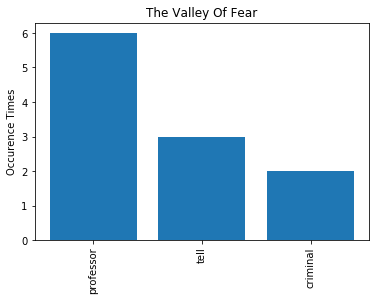

In [217]:
from groupings import *
dict_1 = count_occurences(find_groupings(marked_text, 'mcginty'))
dict_1 = count_occurences(find_groupings(marked_text, 'moriarty'))
first3pairs = {k: dict_1[k] for k in list(dict_1)[:3]}
x = first3pairs.keys()
y = first3pairs.values()
plt.bar(x, y)
plt.xticks(rotation=90)
plt.ylabel('Occurence Times')
plt.title('The Valley Of Fear')   

## 5. When and how the detective/detectives and the perpetrators co-occur

In [218]:
m_1 = get_matches(marked_text, 'sherlock')
m_2 = get_matches(marked_text, 'Mcginty')
co_occur (m_1, m_2)
m_1 = get_matches(marked_text, 'watson')
m_2 = get_matches(marked_text, 'Mcginty')
co_occur (m_1, m_2)
m_1 = get_matches(marked_text, 'sherlock')
m_2 = get_matches(marked_text, 'Moriarty')
co_occur (m_1, m_2)
m_1 = get_matches(marked_text, 'watson')
m_2 = get_matches(marked_text, 'Moriarty')
co_occur (m_1, m_2)

No co-occur
Chapter 14, Sentence 280: deviltry watson
Chapter 14, Sentence 253: mcginty meet fate scaffold cringe whine hour come
Chapter 1, Sentence 2: sherlock holmes remark impatiently
Chapter 1, Sentence 20: hear speak professor moriarty
Chapter 1, Sentence 15: porlock watson nom de plume mere identification mark lie shifty evasive personality
Chapter 1, Sentence 20: hear speak professor moriarty


## 6. When are other suspects first introduced

In [219]:
m = get_matches(marked_text, 'cecil')[0]
chap, sent = get_chapter_sentence(m)
print(f'{chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'barker')[0]
chap, sent = get_chapter_sentence(m)
print(f' {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

3 sentence 39
"cecil james barker hales lodge hampstead"
---
 3 sentence 39
"cecil james barker hales lodge hampstead"


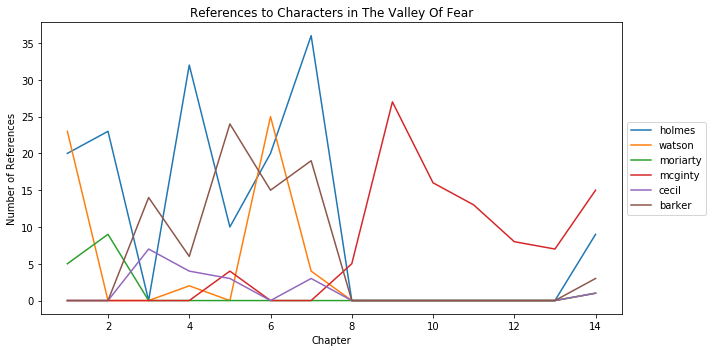

In [220]:
plot_count_per_chapter(chapter_sentences_joined, ['holmes', 'watson', 'moriarty', 'mcginty', 'cecil', 'barker'], title='References to Characters in The Valley Of Fear')
plt.savefig('Figures/valley-of-fear-references.png', dpi=500)


---
# The Hound of Baskersville

In [221]:
book_i = 2
book_fn = books[book_i]['fn']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = read_cleaned_text(book_fn, 'clean-data')
chapter_sentences_joined = [' '.join(chapter) for chapter in raw_chapter_sentences]
chapter_sentences_joined = [remove_extra_spaces(chapter) for chapter in chapter_sentences_joined]

## 1. When does the detective (or a pair) occur for the first time - chapter #, the sentence(s) # in a chapter


In [222]:
m = get_matches(marked_text, 'sherlock')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of sherlock in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'watson')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of watson in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

first occurrence of sherlock in chapter 1 sentence 1
"mr sherlock holmes mr sherlock holmes usually late morning save infrequent occasion night seat breakfast table"
---
first occurrence of watson in chapter 1 sentence 9
"watson"


## 2. When is the crime first mentioned - the type of the crime and the details - chapter #, the sentence(s) # in a chapter


In [223]:
m = get_matches(marked_text, 'throat')[1]
chap, sent = get_chapter_sentence(m)
print(f'first crime scene riping out hugo\'s throat chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'beast')[0]
chap, sent = get_chapter_sentence(m)
print(f'first crime scene description of hound chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')


first crime scene riping out hugo's throat chapter 2 sentence 62
"look thing tear throat hugo baskerville turn blaze eye drip jaw shriek fear ride dear life scream moor"
---
first crime scene description of hound chapter 2 sentence 61
"sight body body hugo baskerville lie near raise hair head dare devil roysterers stand hugo pluck throat stand foul thing great black beast shape like hound large hound mortal eye rest"


## 3. When is the perpetrator first mentioned - chapter #, the sentence(s) # in a chapter


In [224]:
m = get_matches(marked_text, 'stapleton')[0]
chap, sent = get_chapter_sentence(m)
print(f'first mention of jack stapleton chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')

m = get_matches(marked_text, 'rodger')[0]
chap, sent = get_chapter_sentence(m)
print(f'first mention of rodger baskerville (stapleton\'s real name) chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')


first mention of jack stapleton chapter 2 sentence 127
"exception mr frankland lafter hall mr stapleton naturalist man education mile"
---
first mention of rodger baskerville (stapleton's real name) chapter 2 sentence 69
"hugo baskerville son rodger john instruction thereof sister elizabeth"


## 4. What are the three words that occur around the perpetrator on each mention

Text(0.5, 1.0, 'The Hound Of Baskervilles')

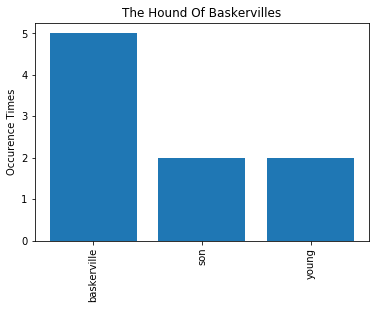

In [225]:
from groupings import *
dict_1 = count_occurences(find_groupings(marked_text, 'stapleton'))
dict_1 = count_occurences(find_groupings(marked_text, 'rodger'))
first3pairs = {k: dict_1[k] for k in list(dict_1)[:3]}
x = first3pairs.keys()
y = first3pairs.values()
plt.bar(x, y)
plt.xticks(rotation=90)
plt.ylabel('Occurence Times')
plt.title('The Hound Of Baskervilles')   

## 5. When and how the detective/detectives and the perpetrators co-occur

In [226]:
m_1 = get_matches(marked_text, 'sherlock')
m_2 = get_matches(marked_text, 'Stapleton')
co_occur (m_1, m_2)
m_1 = get_matches(marked_text, 'watson')
m_2 = get_matches(marked_text, 'Stapleton')
co_occur (m_1, m_2)
m_1 = get_matches(marked_text, 'sherlock')
m_2 = get_matches(marked_text, 'Rodger')
co_occur (m_1, m_2)
m_1 = get_matches(marked_text, 'watson')
m_2 = get_matches(marked_text, 'Rodger')
co_occur (m_1, m_2)

Chapter 2, Sentence 116: thank say sherlock holmes call attention case certainly present feature interest
Chapter 2, Sentence 127: exception mr frankland lafter hall mr stapleton naturalist man education mile
Chapter 3, Sentence 165: delightful freshness watson make pleasure exercise small power possess expense
Chapter 3, Sentence 192: house indicate residence naturalist stapleton remember right
Chapter 2, Sentence 70: dr mortimer finish read singular narrative push spectacle forehead stare mr sherlock holmes
Chapter 2, Sentence 69: hugo baskerville son rodger john instruction thereof sister elizabeth
No co-occur


## 6. When are other suspects first introduced


In [227]:
m = get_matches(marked_text, 'Barrymore')[0]
chap, sent = get_chapter_sentence(m)
print(f'{chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'Beryl')[0]
chap, sent = get_chapter_sentence(m)
print(f' {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

2 sentence 91
"spite considerable wealth simple personal taste indoor servant baskerville hall consist marry couple name barrymore husband act butler wife housekeeper"
---
 7 sentence 244
"halloa beryl"


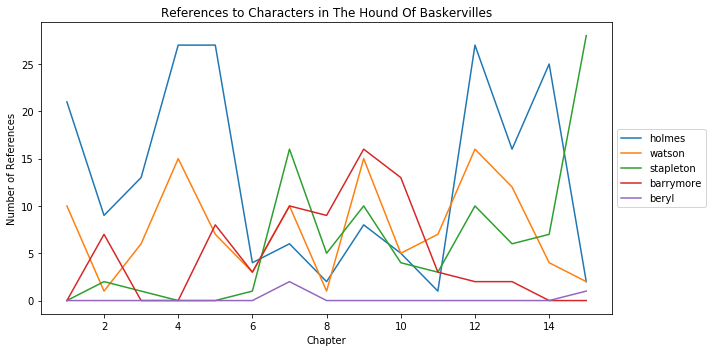

In [228]:
plot_count_per_chapter(chapter_sentences_joined, ['holmes', 'watson', 'stapleton', 'barrymore', 'beryl'], title='References to Characters in The Hound Of Baskervilles')
plt.savefig('Figures/hound-of-baskervilles-references.png', dpi=500)


---
# The Mystery of Cloomber
Could not find good summary of this novel online

In [229]:
book_i = 3
book_fn = books[book_i]['fn']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = read_cleaned_text(book_fn, 'clean-data')
chapter_sentences_joined = [' '.join(chapter) for chapter in raw_chapter_sentences]
chapter_sentences_joined = [remove_extra_spaces(chapter) for chapter in chapter_sentences_joined]

## 1. When does the detective (or a pair) occur for the first time - chapter #, the sentence(s) # in a chapter

In [230]:
m = get_matches(marked_text, 'fothergill')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of john fothergill west in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')


first occurrence of john fothergill west in chapter 1 sentence 1
"hegira wests edinburgh john fothergill west student law university st"


## 2. When is the crime first mentioned - the type of the crime and the details - chapter #, the sentence(s) # in a chapter


In [231]:
# TODO: I cannot find any explicitly mentioned crimes in this dang book
m = get_matches(marked_text, 'murder')
print_all_matches(m)
print('---')
m = get_matches(marked_text, 'kill')
print_all_matches(m)
print('---')
m = get_matches(marked_text, 'killer')
print_all_matches(m)
print('---')
m = get_matches(marked_text, 'stab')
print_all_matches(m)
print('---')
m = get_matches(marked_text, 'shoot')
print_all_matches(m)
# print(f'first occurrence of john fothergill west in chapter {chap+1} sentence {sent+1}')
# print(f'"{m.group(0).split("))) ")[1]}"')

Chapter 15, Sentence 162: man blood cry voice thunder speak excellent english place prayer meditation murder
---
Chapter 9, Sentence 51: hard kill wander jew
Chapter 13, Sentence 28: shock idea kill sheep fish benefit say die hand take life animal
Chapter 13, Sentence 99: uncertainty kill
Chapter 15, Sentence 174: loss affair insignificant kill wound
---
Chapter 15, Sentence 108: compare vermin killer
---
Chapter 15, Sentence 134: gun unlimbered grape pour little infantry force advance double shoot stab overtake
Chapter 15, Sentence 203: think fellow ghazi afghan fanatic steal intention stab idea mind spring couch defend power unaccountably lack
---
Chapter 2, Sentence 9: sight branksome sign work man save high white tower cloomber hall shoot like headstone giant grave amid fir larch gird round
Chapter 7, Sentence 4: countryside square white tower shoot tree beneath tower ill fate family watch wait wait watch
Chapter 7, Sentence 29: instead reply question eye time silence sullen yellow

## 3. When is the perpetrator first mentioned - chapter #, the sentence(s) # in a chapter


In [232]:
m = get_matches(marked_text, 'heatherstone')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of john fothergill west in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')


first occurrence of john fothergill west in chapter 1 sentence 10
"heatherstone"


## 4. What are the three words that occur around the perpetrator on each mention

## 5. When and how the detective/detectives and the perpetrators co-occur

In [233]:
m_1 = get_matches(marked_text, 'fothergill')
m_2 = get_matches(marked_text, 'heatherstone')
co_occur (m_1, m_2)

Chapter 1, Sentence 1: hegira wests edinburgh john fothergill west student law university st
Chapter 1, Sentence 10: heatherstone


## 6. When are other suspects first introduced

In [234]:
m = get_matches(marked_text, 'rufus')[0]
chap, sent = get_chapter_sentence(m)
print(f'{chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'smith')[0]
chap, sent = get_chapter_sentence(m)
print(f' {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

7 sentence 1
"corporal rufus smith come cloomber make statement purposely couch bald simple language fear accuse colour narrative sake effect"
---
 7 sentence 1
"corporal rufus smith come cloomber make statement purposely couch bald simple language fear accuse colour narrative sake effect"


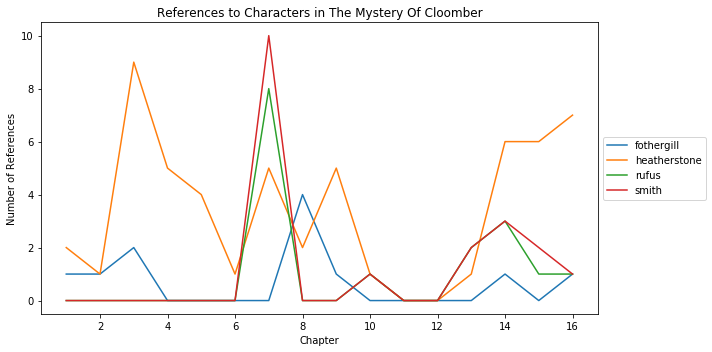

In [235]:
plot_count_per_chapter(chapter_sentences_joined, ['fothergill', 'heatherstone', 'rufus', 'smith'], title='References to Characters in The Mystery Of Cloomber')
plt.savefig('Figures/mystery-of-cloomber-references.png', dpi=500)


---
# The Sign of Four

In [236]:
book_i = 4
book_fn = books[book_i]['fn']
raw_text, raw_chapters, raw_chapter_sentences, marked_text = read_cleaned_text(book_fn, 'clean-data')
chapter_sentences_joined = [' '.join(chapter) for chapter in raw_chapter_sentences]
chapter_sentences_joined = [remove_extra_spaces(chapter) for chapter in chapter_sentences_joined]

## 1. When does the detective (or a pair) occur for the first time - chapter #, the sentence(s) # in a chapter

In [237]:
m = get_matches(marked_text, 'sherlock')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of sherlock in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'watson')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of watson in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

first occurrence of sherlock in chapter 1 sentence 1
"science deduction sherlock holmes take bottle corner mantel piece hypodermic syringe neat morocco case"
---
first occurrence of watson in chapter 1 sentence 20
"right watson say"


## 2. When is the crime first mentioned - the type of the crime and the details - chapter #, the sentence(s) # in a chapter

In [238]:
chapter_5 = get_chapter_from_marked(marked_text, 4)

m = get_matches(marked_text, 'murder')[2]
chap, sent = get_chapter_sentence(m)
print(f'reference to murder in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(chapter_5, 'thorn')[0]
print(f'reference to murder weapon in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(chapter_5, 'treasure')[2]
print(f'reference to treasure that was then stolen in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(chapter_5, 'note')[0]
print(f'reference to note left at murder scene in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')


reference to murder in chapter 5 sentence 157
"mean murder say stoop dead man"
---
reference to murder weapon in chapter 5 sentence 157
"point look like long dark thorn stick skin ear"
---
reference to treasure that was then stolen in chapter 5 sentence 157
"rob treasure"
---
reference to note left at murder scene in chapter 5 sentence 157
"tear sheet note paper word scrawl"


## 3. When is the perpetrator first mentioned - chapter #, the sentence(s) # in a chapter


In [239]:
m = get_matches(marked_text, 'jonathan')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of jonathan small in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'tonga')[0]
chap, sent = get_chapter_sentence(m)
print(f'first occurrence of tonga in chapter {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

first occurrence of jonathan small in chapter 3 sentence 50
"write rough coarse character sign jonathan small mahomet singh abdullah khan dost akbar"
---
first occurrence of tonga in chapter 11 sentence 13
"little hell hound tonga shoot curse dart"


## 4. What are the three words that occur around the perpetrator on each mention

Text(0.5, 1.0, 'The Sign Of The Four')

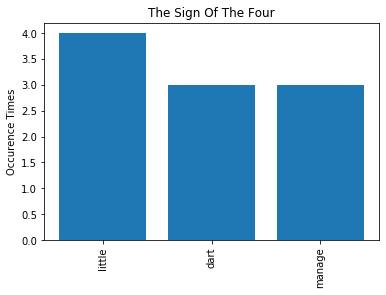

In [240]:
from groupings import *
dict_1 = count_occurences(find_groupings(marked_text, 'jonathan'))
dict_1 = count_occurences(find_groupings(marked_text, 'tonga'))
first3pairs = {k: dict_1[k] for k in list(dict_1)[:3]}
x = first3pairs.keys()
y = first3pairs.values()
plt.bar(x, y)
plt.xticks(rotation=90)
plt.ylabel('Occurence Times')
plt.title('The Sign Of The Four')   

## 5. When and how the detective/detectives and the perpetrators co-occur

In [241]:
m_1 = get_matches(marked_text, 'sherlock')
m_2 = get_matches(marked_text, 'Jonathan')
co_occur (m_1, m_2)
m_1 = get_matches(marked_text, 'watson')
m_2 = get_matches(marked_text, 'Jonathan')
co_occur (m_1, m_2)
m_1 = get_matches(marked_text, 'sherlock')
m_2 = get_matches(marked_text, 'Tonga')
co_occur (m_1, m_2)
m_1 = get_matches(marked_text, 'watson')
m_2 = get_matches(marked_text, 'Tonga')
co_occur (m_1, m_2)

Chapter 3, Sentence 28: difficulty certainly difficulty say sherlock holmes pensively
Chapter 3, Sentence 50: write rough coarse character sign jonathan small mahomet singh abdullah khan dost akbar
Chapter 6, Sentence 231: word watson
Chapter 6, Sentence 221: reason believe jonathan small
Chapter 11, Sentence 57: slight smile play sherlock holmes face speech lose
Chapter 11, Sentence 34: half kill tonga scramble
Chapter 11, Sentence 58: vauxhall bridge presently say jones shall land dr watson treasure box
Chapter 11, Sentence 34: half kill tonga scramble


## 6. When are other suspects first introduced

In [242]:
m = get_matches(marked_text, 'Thaddeus')[0]
chap, sent = get_chapter_sentence(m)
print(f'{chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')
print('---')
m = get_matches(marked_text, 'Sholto')[0]
chap, sent = get_chapter_sentence(m)
print(f' {chap+1} sentence {sent+1}')
print(f'"{m.group(0).split("))) ")[1]}"')

4 sentence 19
"mr thaddeus sholto say little man jerk smile"
---
 2 sentence 45
"know major sholto regiment 34th bombay infantry"


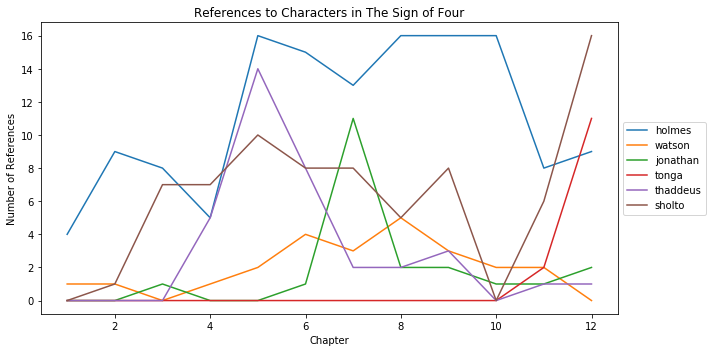

In [243]:
plot_count_per_chapter(chapter_sentences_joined, ['holmes', 'watson', 'jonathan', 'tonga', 'thaddeus', 'sholto'], title='References to Characters in The Sign of Four')
plt.savefig('Figures/sign-of-four-character-references.png', dpi=500)

# Plot

In [244]:
def draw_scatter (x1,x2,x3,x4, x5,y1,y2,y3,y4,y5):
    names = ['A Study In Scarlet', 'The Valley Of Fear', 'The Hound Of Baskervilles', 'The Mystery Of Cloomber', 'The Sign Of Four']
    plt.scatter(x1, y1, label=names[0])
    plt.scatter(x2, y2, label=names[1])
    plt.scatter(x3, y3, label=names[2])
    plt.scatter(x4, y4, label=names[3])
    plt.scatter(x5, y5, label=names[4])  

    plt.legend(loc=2, bbox_to_anchor=(-0.03, 1.3), ncol=2)
    plt.xlabel("Chapter")
    plt.ylabel("Sentence")
    plt.grid(color='lightgrey', linestyle='-', linewidth=.5)

## Question 1

(0, 5)

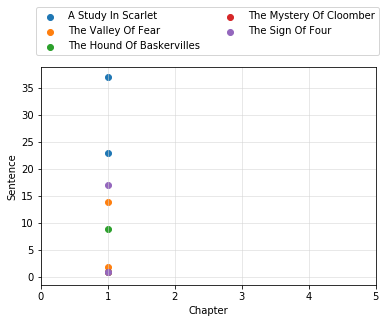

In [245]:
x1 = [1,1]
x2 = [1,1]
x3 = [1,1]
x4 = [1]
x5 = [1,1]
y1 = [37,23]
y2 = [2,14]
y3 = [1,9]
y4 = [1]
y5 = [1,17]


draw_scatter (x1,x2,x3,x4, x5,y1,y2,y3,y4,y5)
plt.xlim((0,5))

## Question_2

(0, 8)

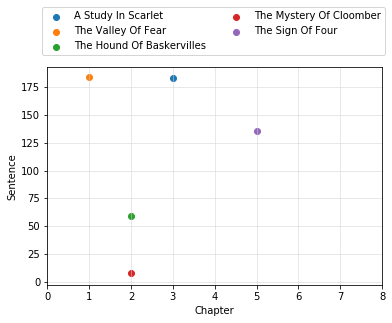

In [246]:
x1 = [3]
x2 = [1]
x3 = [2]
x4 = [2]
x5 = [5]
y1 = [183]
y2 = [184]
y3 = [59]
y4 = [8]
y5 = [136]


draw_scatter (x1,x2,x3,x4, x5,y1,y2,y3,y4,y5)
plt.xlim((0,8))

## Question_3

(0, 5)

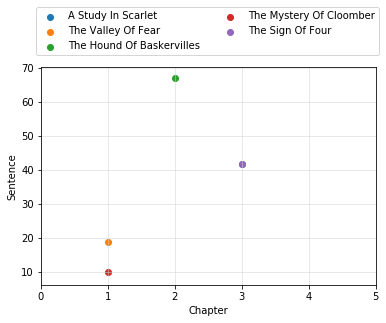

In [247]:
x1 = [3]
x2 = [1]
x3 = [2]
x4 = [1]
x5 = [3]
y1 = [42]
y2 = [19]
y3 = [67]
y4 = [10]
y5 = [42]


draw_scatter (x1,x2,x3,x4, x5,y1,y2,y3,y4,y5)
plt.xlim((0,5))

## Question_5 (Detective)

(0, 8)

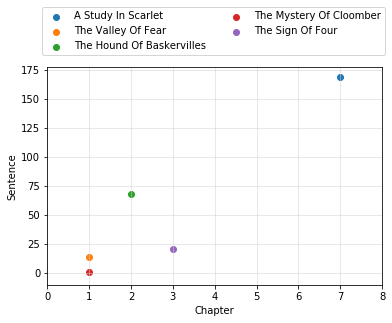

In [248]:
x1 = [7]
x2 = [1]
x3 = [2]
x4 = [1]
x5 = [3]
y1 = [169]
y2 = [14]
y3 = [68]
y4 = [1]
y5 = [21]


draw_scatter (x1,x2,x3,x4, x5,y1,y2,y3,y4,y5)
plt.xlim((0,8))

## Question_5 (Perp)

(0, 8)

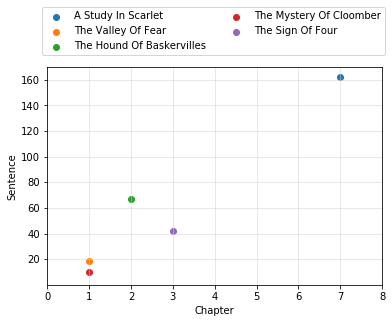

In [249]:
x1 = [7]
x2 = [1]
x3 = [2]
x4 = [1]
x5 = [3]
y1 = [162]
y2 = [19]
y3 = [67]
y4 = [10]
y5 = [42]


draw_scatter (x1,x2,x3,x4, x5,y1,y2,y3,y4,y5)
plt.xlim((0,8))

## Question_6

(0, 8)

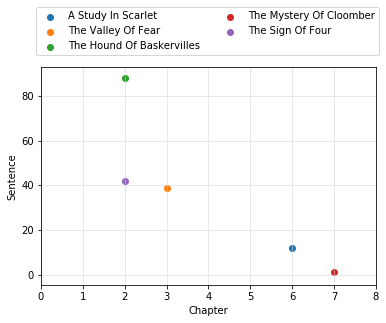

In [250]:
x1 = [6]
x2 = [3]
x3 = [2]
x4 = [7]
x5 = [2]
y1 = [12]
y2 = [39]
y3 = [88]
y4 = [1]
y5 = [42]


draw_scatter (x1,x2,x3,x4, x5,y1,y2,y3,y4,y5)
plt.xlim((0,8))

---
# Analysis

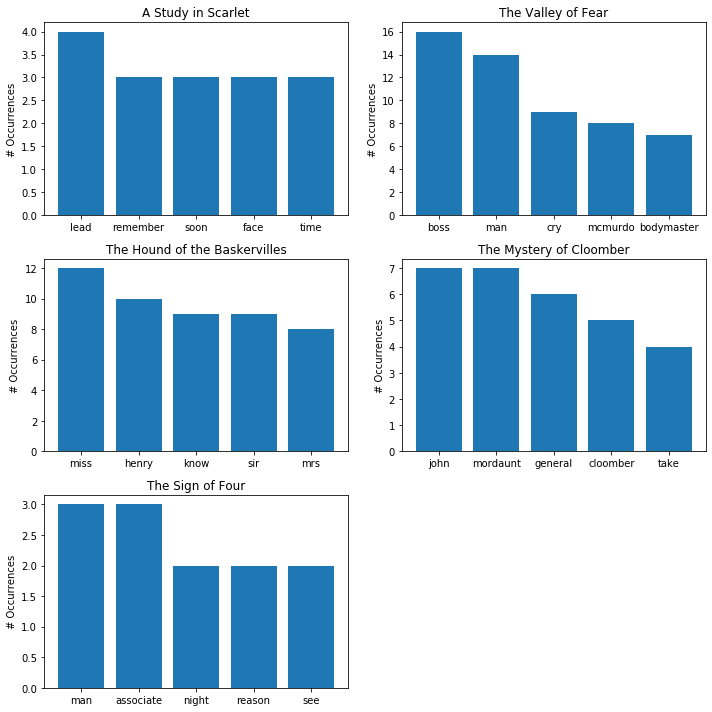

In [251]:
from groupings import count_occurences, graph_occurences


fig = plt.figure(figsize=(10,10))


raw_text = read_cleaned_text(books[0]['fn'], 'clean-data')[0]
raw_text = raw_text.replace('.',' ')
raw_text = raw_text.replace('jefferson hope','jefferson')
raw_text = remove_extra_spaces(raw_text)
dict = count_occurences(find_groupings(raw_text, 'jefferson')) #a study in scarlet
del dict['say'] # dont care about say

graph_occurences(fig.add_subplot(3,2,1), dict, 'A Study in Scarlet')

raw_text = read_cleaned_text(books[1]['fn'], 'clean-data')[0]
raw_text = raw_text.replace('.',' ')
raw_text = raw_text.replace('professor moriarty','moriarty')
raw_text = remove_extra_spaces(raw_text)
dict = count_occurences(find_groupings(raw_text, 'mcginty')) #the valley of fear
del dict['say'] # dont care about say

graph_occurences(fig.add_subplot(3,2,2), dict, 'The Valley of Fear')



raw_text = read_cleaned_text(books[2]['fn'], 'clean-data')[0]
raw_text = raw_text.replace('.',' ')
raw_text = raw_text.replace('jack stapleton','stapleton')
raw_text = remove_extra_spaces(raw_text)
dict = count_occurences(find_groupings(raw_text, 'stapleton')) #the hound of the baskervilles
del dict['say'] # dont care about say

graph_occurences(fig.add_subplot(3,2,3), dict, 'The Hound of the Baskervilles')



raw_text = read_cleaned_text(books[3]['fn'], 'clean-data')[0]
raw_text = raw_text.replace('.',' ')
raw_text = raw_text.replace('general heatherstone','heatherstone')
raw_text = raw_text.replace('berthier heatherstone','heatherstone')
raw_text = remove_extra_spaces(raw_text)
dict = count_occurences(find_groupings(raw_text, 'heatherstone'))  #mystery of cloomber
del dict['j']
del dict['b']
del dict['mrs'] # mrs heatherstone is not who we are looking for
del dict['say'] # dont care about say

graph_occurences(fig.add_subplot(3,2,4), dict, 'The Mystery of Cloomber')


raw_text = read_cleaned_text(books[4]['fn'], 'clean-data')[0]
raw_text = raw_text.replace('.',' ')
raw_text = raw_text.replace('jonathan small','jonathan')
raw_text = remove_extra_spaces(raw_text)
dict = count_occurences(find_groupings(raw_text, 'jonathan')) #the sign of four
del dict['say'] # dont care about say

graph_occurences(fig.add_subplot(3,2,5), dict, 'The Sign of Four')

plt.tight_layout()
plt.savefig('Figures/co-occurences.png', dpi=500)
plt.show()

---
# Archive

In [ ]:
def porters_alg(text):
    # https://vijinimallawaarachchi.com/2017/05/09/porter-stemming-algorithm/#:~:text=The%20Porter%20Stemming%20algorithm%20(or,of%20Information%20Retrieval%20(IR).
    # https://tartarus.org/martin/PorterStemmer/
    m = re.match(r'(\w+?)(?=ly|es|(?<!s)s|y)', text)
    print(m.groups())
porters_alg('caresses days cates')

In [ ]:
raw_chapters[0]

In [ ]:
raw_chapters[1]

In [ ]:
list(filter(lambda c: len(c) > 50, raw_chapters))

In [ ]:
from utils.regex_utils import *

In [ ]:
textloc = "books/a-study-in-scarlet.txt"
stopwordloc = 'project1\stopwords.txt'
text = GetTextFromFile(textloc)
stopwords = GetStopWords(stopwordloc)
clean_text = GetCleanText(text, stopwords)
wordlist = GetUniqueWordList(clean_text)
chapters = GetChapterTextList(text, stopwords)
chapters_wordlist = GetChapterWordList(chapters)

In [ ]:
textloc = "books/a-study-in-scarlet.txt"
stopwordloc = 'project1\stopwords.txt'
text = GetTextFromFile(textloc)
stopwords = GetStopWords(stopwordloc)
clean_text = GetCleanText(text, stopwords)
wordlist = GetUniqueWordList(clean_text)
chapters = GetChapterTextList(text, stopwords)
chapters_wordlist = GetChapterWordList(chapters)

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
with open('stopwords.txt', 'w',encoding='utf-8') as f:
    for w in nlp.Defaults.stop_words:
        f.write(w + '\n')


In [ ]:
len(nlp.Defaults.stop_words)

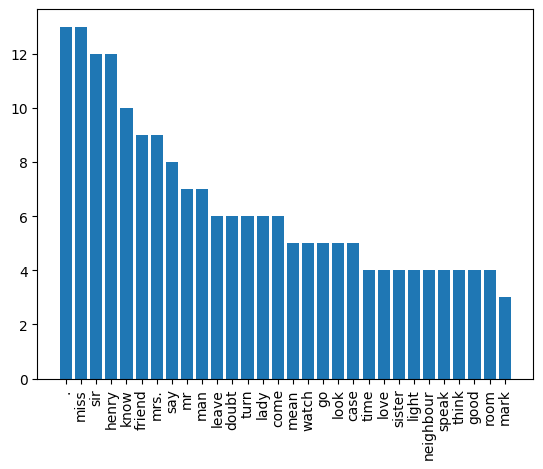